In [1]:
import xarray as xr
from pathlib import Path
import seaborn as sns
from sklearn import preprocessing
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn import linear_model, svm, ensemble, neural_network, decomposition
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

from lightgbm import LGBMRegressor, plot_importance, plot_split_value_histogram

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train_ds = xr.open_dataset('train_set.nc', engine='h5netcdf')
val_ds = xr.open_dataset('validate_set.nc', engine='h5netcdf')

In [3]:
yvar = 'cloud_top_altitude'

In [4]:
import pickle
with open('cloud_mask.pkl', 'rb') as f:
    mask_model = pickle.load(f)
with open('cloud_type.pkl', 'rb') as f:
    type_model = pickle.load(f)
    

In [5]:
def process_ds(ds, real_cloudy=False):
    vars_ = [f'CMI_C{c:02d}' for c in range(1, 17)] 
    if not real_cloudy:
        vars_ += ['cloud_layers']
    df = ds[vars_].isel(near=0).to_dataframe()
    df = df.drop(columns=[c for c in df.columns if c not in vars_])
    nans = df.isna().any(axis=1) 
    if not real_cloudy:
        nans |= df['cloud_layers'] == 0
        del df['cloud_layers']
        X = df[~nans]
    else:
        cloud_prob = mask_model.predict_proba(df[~nans].values)
        X = df[~nans]
        X = X[cloud_prob[:, 1] >= 0.5]
    y = ds[yvar].values[X.index]
    # y is nan when no cloud
    ynan = np.isnan(y)
    y[ynan] = 0
    return X, y

In [6]:
X, y = process_ds(train_ds)
X.shape, y.shape

((177681, 16), (177681,))

In [7]:
X_val, y_val = process_ds(val_ds)
X_val.shape, y_val.shape

((40140, 16), (40140,))

In [8]:
X_val_cld, y_val_cld = process_ds(val_ds, True)

In [9]:
reg = neural_network.MLPRegressor(
    verbose=False, activation='relu', alpha=1e-4, hidden_layer_sizes=(50,),
                                  
    tol=1e-4, solver='adam')
model = Pipeline([
    ('scaler', preprocessing.RobustScaler()),
    ('pca', decomposition.PCA(whiten=True)),
    ('reg', reg)
])
    
%time model.fit(X.values, y)

CPU times: user 7min 7s, sys: 6min 54s, total: 14min 2s
Wall time: 2min 2s


Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('reg',
                 MLPRegressor(activation='relu', alpha=0.0001,
                              batch_size='auto', beta_1=0.9, beta_2=0.999,
                              early_stopping=False, epsilon=1e-08,
                              hidden_layer_sizes=(50,),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=200, momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=None,

In [10]:
%%time
model.score(X, y), model.score(X_val, y_val), model.score(X_val_cld, y_val_cld)

CPU times: user 717 ms, sys: 630 ms, total: 1.35 s
Wall time: 208 ms


(0.8204643655044819, 0.8098380022010532, 0.48077596586330607)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.01,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8075b5ca90>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

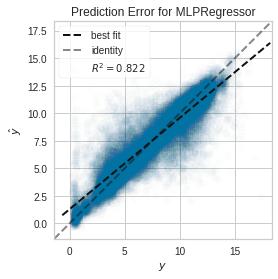

In [11]:
prediction_error(model, X, y, alpha=0.01)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.01,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f80721ad198>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

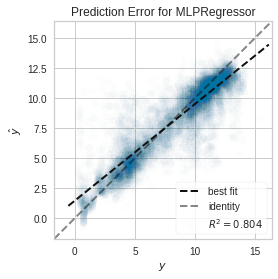

In [12]:
prediction_error(model, X_val, y_val, is_fitted=True, alpha=0.01)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.01,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f80720a3c18>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

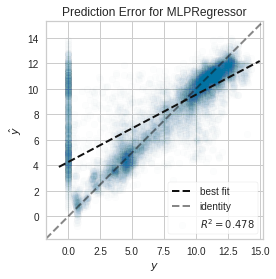

In [13]:
prediction_error(model, X_val_cld, y_val_cld, is_fitted=True, alpha=0.01)

Regression does well except when points are misclassified as cloudy when they are actually clear